In [23]:
import os
os.chdir(os.path.pardir)

import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt

In [24]:
from gglasso.helper.data_generation import group_power_network, sample_covariance_matrix
from gglasso.problem import glasso_problem
from gglasso.helper.basic_linalg import adjacency_matrix
from gglasso.helper.utils import sparsity, zero_replacement, normalize, log_transform

# Import preprocessed soil data

In [26]:
soil = pd.read_table('/Users/oleg.vlasovetc/Public/GGLasso/data/soil/soil_116.csv', sep=',')
soil.head()

,1124701,697997,203969,205391,843189,3431064,156611,2867534,4440638,216549,...,160908,1137157,4341561,143135,4409771,171768,83531,151283,1108390,4478794
0,16.0,3.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,7.0,...,2.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0
1,15.0,5.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,12.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,25.0,1.0
2,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
3,9.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,...,6.0,1.0,1.0,1.0,2.0,22.0,3.0,4.0,1.0,1.0
4,14.0,68.0,1.0,1.0,1.0,4.0,1.0,1.0,10.0,3.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,1.0


In [6]:
X_soil = np.array(soil)
X_soil.shape

(89, 116)

# Log-transform

In [10]:
X = normalize(X_soil)

Note: X is scaled with geometric mean, and should be a dataframe of form (p,N)

In [15]:
X = log_transform(pd.DataFrame(X.T))

# Calculate covariance and scale to correlations

In [16]:
S0 = np.cov(X.values, bias = True)

In [17]:
# scale covariances to correlations
scale = np.tile(np.sqrt(np.diag(S0)),(S0.shape[0],1))
scale = scale.T * scale

S = S0 / scale

# GGLasso problem

In [20]:
P = glasso_problem(S, X.shape[1], reg_params = {'lambda1': 0.05}, latent = False, do_scaling = False)
print(P)

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}


In [21]:
lambda1_range = np.logspace(0, -3, 20)
modelselect_params = {'lambda1_range': lambda1_range}

P.model_selection(modelselect_params = modelselect_params, method = 'eBIC', gamma = 1)

# regularization parameters are set to the best ones found during model selection
print(P.reg_params)

ADMM terminated after 34 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 104 iterations with status: optimal.
ADMM terminated after 145 iterations with status: optimal.
ADMM terminated after 162 iterations with status: optimal.
ADMM terminated after 90 iterations with status: optimal.
ADMM terminated after 129 iterations with status: optimal.
ADMM terminated after 178 iterations with status: optimal.
ADMM terminated after 223 iterations with status: optimal.
ADMM terminated after 292 iterations with status: optimal.
ADMM terminated after 397 iterations with status: optimal.
ADMM terminated after 537 iterations with status: optimal.
ADMM terminated after 762 iterations with status: optimal.
ADMM

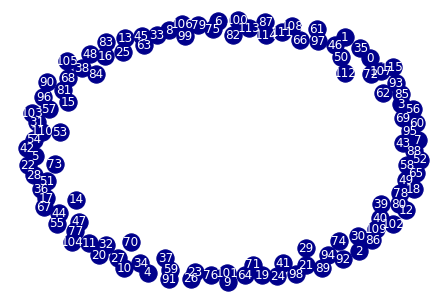

In [22]:
sol = P.solution.precision_
P.solution.calc_adjacency()


plt.figure()
G1 = nx.from_numpy_array(P.solution.adjacency_)
nx.draw_spring(G1, node_color = "darkblue", edge_color = "darkblue", font_color = 'white', with_labels = True)